# Downloading SAMOS data from MarineFlux ERDDAP server

In [13]:
from erddapy import ERDDAP
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy.ma as ma

## Create the ERDDAP request

In [14]:
extent = [280.0, 290.0, 30.0, 40.0] # [lon-, lon+, lat-, lat+]
flux_algorithms = ["S88", "B23", "C36"]

In [28]:
erddap_samos = dict()
for algo in flux_algorithms:
  erddap_samos[algo] = ERDDAP(
    server="http://erddap-samos.coaps.fsu.edu/erddap",
    protocol="tabledap",
  )

  erddap_samos[algo].dataset_id = f"SAMOS_Fluxes_{algo}_20240624"
  erddap_samos[algo].constraints = {
      "time>=": "2021-01-01T00:00:00Z",
      "time<=": "2022-01-01T00:00:00Z",
      "longitude>=": extent[0],
      "longitude<=": extent[1],
      "latitude>=": extent[2],
      "latitude<=": extent[3],
  }
  erddap_samos[algo].variables = [
      "hfls",
      "hfss",
      "tau",
  ]

### URLs for ERDDAP request can be retrieved

In [16]:
for algo in flux_algorithms:
    erddap_samos[algo].response = "csv"
    print(f'Download {algo} CSV: {erddap_samos[algo].get_download_url()}')

    erddap_samos[algo].response = "html"
    print(f'View {algo} download form on ERDDAP server: {erddap_samos[algo].get_download_url()}\n')

Download S88 CSV: http://erddap-samos.coaps.fsu.edu/erddap/tabledap/SAMOS_Fluxes_S88_20240624.csv?hfls,hfss,tau&time>=1609459200.0&time<=1640995200.0&longitude>=280.0&longitude<=290.0&latitude>=30.0&latitude<=40.0
View S88 download form on ERDDAP server: http://erddap-samos.coaps.fsu.edu/erddap/tabledap/SAMOS_Fluxes_S88_20240624.html?hfls,hfss,tau&time>=1609459200.0&time<=1640995200.0&longitude>=280.0&longitude<=290.0&latitude>=30.0&latitude<=40.0

Download B23 CSV: http://erddap-samos.coaps.fsu.edu/erddap/tabledap/SAMOS_Fluxes_B23_20240624.csv?hfls,hfss,tau&time>=1609459200.0&time<=1640995200.0&longitude>=280.0&longitude<=290.0&latitude>=30.0&latitude<=40.0
View B23 download form on ERDDAP server: http://erddap-samos.coaps.fsu.edu/erddap/tabledap/SAMOS_Fluxes_B23_20240624.html?hfls,hfss,tau&time>=1609459200.0&time<=1640995200.0&longitude>=280.0&longitude<=290.0&latitude>=30.0&latitude<=40.0

Download C36 CSV: http://erddap-samos.coaps.fsu.edu/erddap/tabledap/SAMOS_Fluxes_C36_20240624.

### Request data as CF compliant netCDF4-python object

In [29]:
nc = dict()

for algo in flux_algorithms:
    nc[algo] = erddap_samos[algo].to_ncCF()

    print(nc[algo])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    acknowledgement: NOAA/CPO/COM via award NA21OAR4310262
    cdm_data_type: Point
    comment: These data are all of the input variables and the relevant output variables of bulk flux calculations done on ship observations. When redundant instruments exist, the sensors used for calculations are chosen based on the amount of good data available, determined on a per day basis, using an updated method of the one described in Smith, S. R., N. Lopez, and M. A. Bourassa, 2016: SAMOS air-sea fluxes: 2005–2014. Geoscience Data Journal, 3, 9–19, https://doi.org/10.1002/gdj3.34.
    Conventions: COARDS, CF-1.6, ACDD-1.3
    creator_name: Marine Data Center, Center for Ocean-Atmospheric Prediction Studies, Florida State University, Tallahassee, FL, 32306-2840, USA
    creator_type: institution
    creator_url: https://mdc.coaps.fsu.edu/
    Easternmost_Easting: 290.0002
    featureType: Point
    fl

## Request data as pandas DataFrame

In [18]:
df = dict()

for algo in flux_algorithms:
    df[algo] = erddap_samos[algo].to_pandas()

    print(df[algo])

        hfls (watts meter-2)  hfss (watts meter-2)  tau (newton meter-2)
0                 146.181258            -17.524772              0.200518
1                 147.605470            -15.540669              0.203199
2                 128.855518            -15.154368              0.160450
3                 134.268766            -16.316085              0.184601
4                 127.029346            -13.794150              0.154656
...                      ...                   ...                   ...
409695            236.753046             98.175269              0.187504
409696            181.516763             75.551588              0.100459
409697            241.519492            102.408728              0.212015
409698            266.429420            111.601423              0.271655
409699            278.408334            114.744942              0.291983

[409700 rows x 3 columns]
        hfls (watts meter-2)  hfss (watts meter-2)  tau (newton meter-2)
0                 154.41

## Request data as xarray Dataset

In [31]:
ds = dict()

for algo in flux_algorithms:
    ds[algo] = erddap_samos[algo].to_xarray()

    print(ds[algo])

### Simple plot of latent heat flux

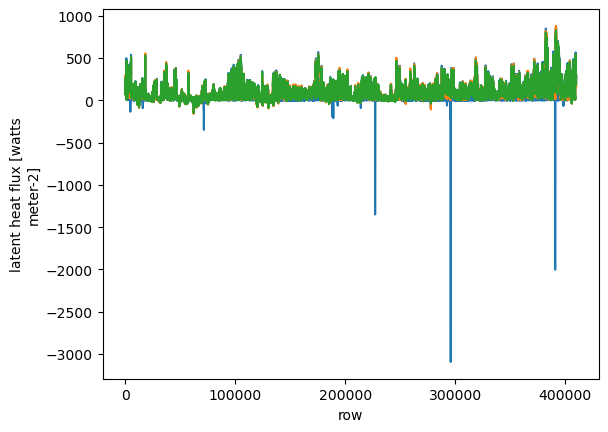

In [20]:
for algo in flux_algorithms:
    ds[algo]['hfls'].plot()

### Latent heat flux plotted as a function of time

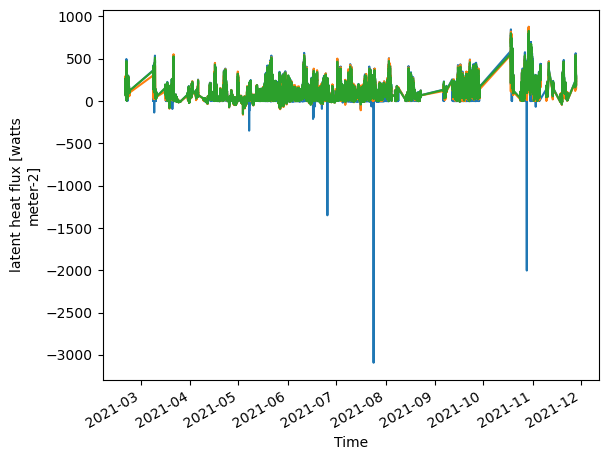

In [21]:
for algo in flux_algorithms:
    ds[algo]['hfls'].plot(x='time')

### Sensible and latent heat fluxes plotted on a map

In [22]:
def plot_shared_colorbar(dataset, vars, cmap='bwr', diverging=True, sort=False):
    height = 4
    figsize = (len(vars) * height, height)
    fig = plt.figure(figsize=figsize, layout='constrained')
    fig.suptitle(dataset.title)

    projection = ccrs.PlateCarree()

    ax_dict = fig.subplot_mosaic(
        [
            vars,
            ['cbar' for var in vars]
        ],
        height_ratios=[20, 1],
        per_subplot_kw={
            tuple(vars): {'projection': projection}
        }
    )

    vmax = -1
    for var in vars:
        ax_dict[var].set_extent(extent, crs=projection)
        ax_dict[var].stock_img()
        ax_dict[var].coastlines()
        ax_dict[var].set_title(f'{dataset[var].long_name} ({dataset[var].units})')

        vmax = max(vmax, ma.max(abs(ma.masked_invalid(ds[algo][var]))))

    if diverging:
        vmin = -vmax
    else:
        vmin = 0

    scatter = []
    for var in vars:
        # sorting the DataArray before plotting makes the higher values show up on top. this is useful for seeing where the high values are, but obscures the negative values.
        if sort:
            da = dataset[var].sortby(dataset[var])
        else:
            da = dataset[var]
        scatter.append(ax_dict[var].scatter(x=da['longitude'], y=da['latitude'], c=da, cmap=cmap, vmin=vmin, vmax=vmax))

    cbar = plt.colorbar(scatter[0], cax=ax_dict['cbar'], orientation='horizontal')

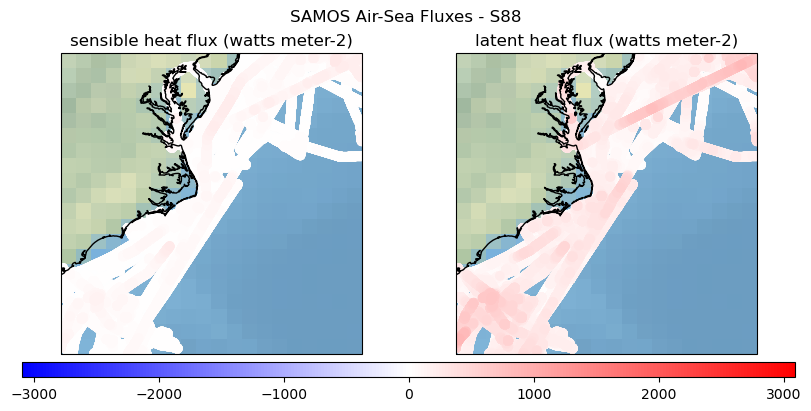

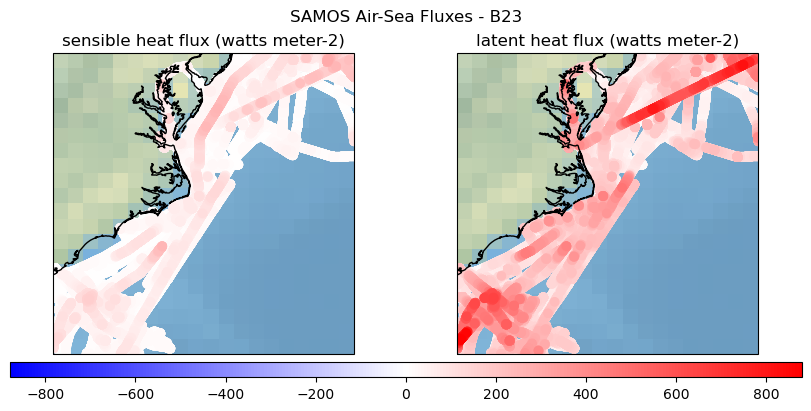

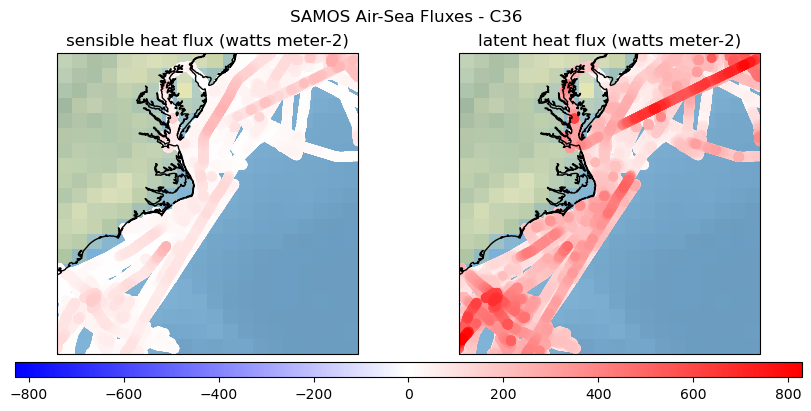

In [23]:
for algo in flux_algorithms:
    plot_shared_colorbar(ds[algo], ['hfss', 'hfls'], sort=True)

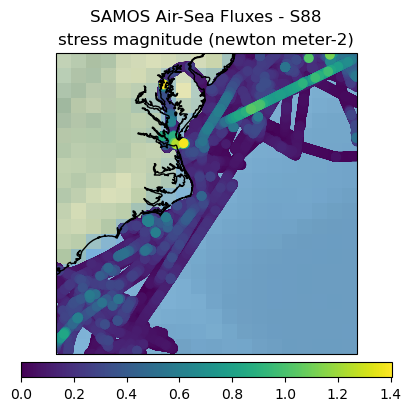

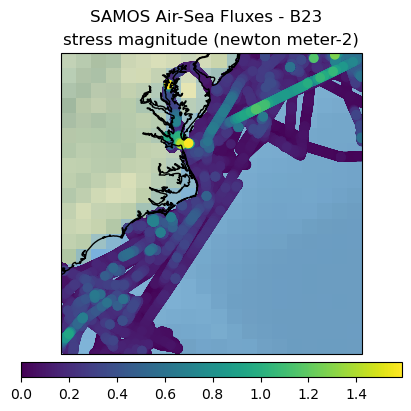

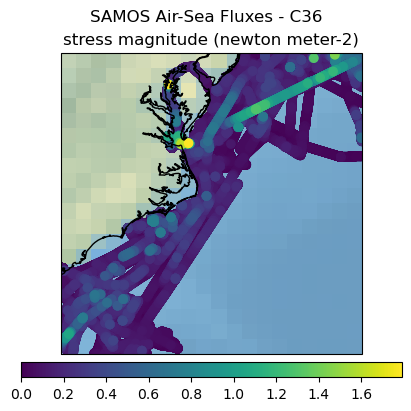

In [24]:
for algo in flux_algorithms:
    plot_shared_colorbar(ds[algo], ['tau'], cmap='viridis', diverging=False, sort=True)

In [25]:
def plot_dataset_comparison(datasets, var, sort=False, cmap='bwr', diverging=True):
    keys = list(datasets.keys())
    height = 4
    figsize = (len(datasets) * height, height)
    fig = plt.figure(figsize=figsize, layout='constrained')
    fig.suptitle(f'{ds[keys[0]][var].long_name} ({ds[keys[0]][var].units})')

    projection = ccrs.PlateCarree()

    ax_dict = fig.subplot_mosaic(
        [
            [algo for algo in keys],
            ['cbar' for algo in keys]
        ],
        height_ratios=[20, 1],
        per_subplot_kw={
            tuple(algo for algo in keys): {'projection': projection}
        }
    )

    vmax = -1
    for algo in keys:
            
        ax_dict[algo].set_extent(extent, crs=projection)
        ax_dict[algo].stock_img()
        ax_dict[algo].coastlines()
        ax_dict[algo].set_title(f'{datasets[algo][var].long_name} ({datasets[algo][var].units})')

        vmax = max(vmax, ma.max(abs(ma.masked_invalid(datasets[algo][var]))))

        ax_dict[algo].set_title(datasets[algo].title)

    if diverging:
        vmin = -vmax
    else:
        vmin = 0

    scatter = []
    for algo in keys:
        # sorting the DataArray before plotting makes the higher values show up on top. this is useful for seeing where the high values are, but obscures the negative values.
        if sort:
            da = datasets[algo][var].sortby(datasets[algo][var])
        else:
            da = datasets[algo][var]
        scatter.append(ax_dict[algo].scatter(x=da['longitude'], y=da['latitude'], c=da, cmap=cmap, vmin=vmin, vmax=vmax))

    cbar = plt.colorbar(scatter[0], cax=ax_dict['cbar'], orientation='horizontal')

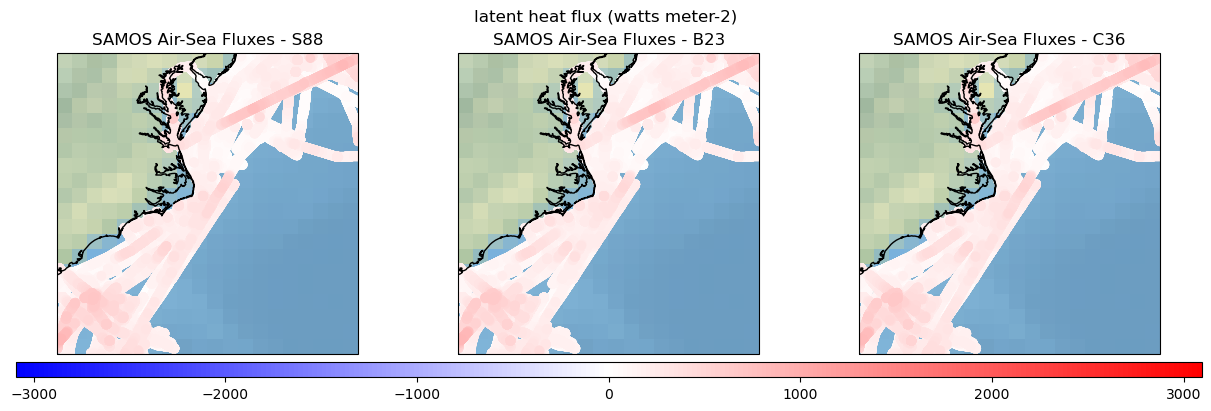

In [26]:
plot_dataset_comparison(ds, 'hfls', sort=True)

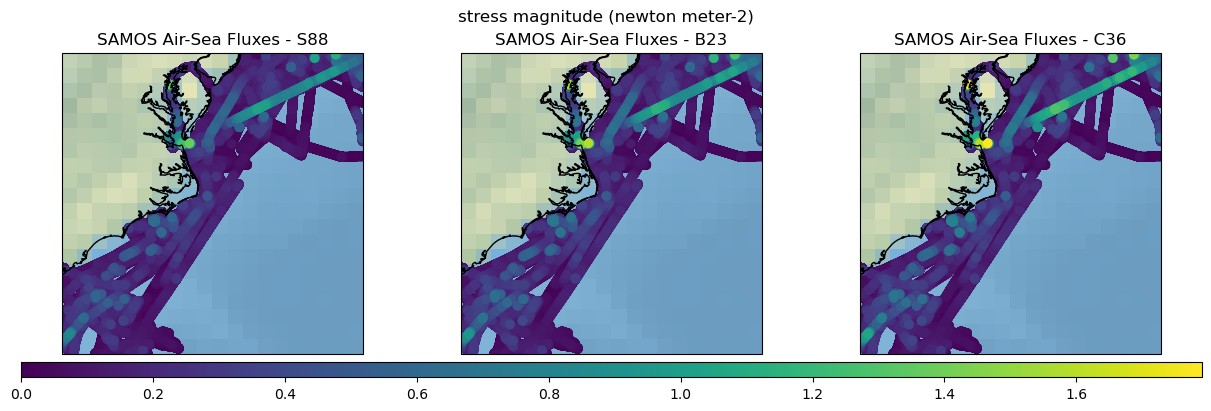

In [27]:
plot_dataset_comparison(ds, 'tau', cmap='viridis', diverging=False, sort=True)